# Práctica 2: Análisis de Sentimientos Supervisado y No Supervisado

### Autor: Taisiia Prymak & Jiahui Chen

En esta práctica se abordará el análisis de sentimientos desde dos enfoques principales: supervisado y no supervisado. El contenido se divide en las siguientes secciones:

1. **Preprocesamiento de Datos**: Se realiza una limpieza y transformación de los datos textuales para facilitar su análisis. Esto incluye la eliminación de ruido, lematización y etiquetado POS (Part-of-Speech).

2. **Modelos Supervisados**: Se entrenan y evalúan modelos supervisados como KNN, Random Forest y SVM para clasificar los documentos en función de su polaridad. Se utiliza GridSearchCV para optimizar los hiperparámetros y se evalúan las métricas de rendimiento.

3. **Modelos No Supervisados**: Se exploran métodos no supervisados para determinar la polaridad de los textos basándose en recursos léxicos como SentiWordNet.

4. **Análisis de Resultados**: Se comparan los resultados obtenidos con ambos enfoques, destacando las ventajas y limitaciones de cada uno.

In [47]:
import nltk
import random
from nltk.corpus import movie_reviews as mr
from sklearn.feature_extraction.text import CountVectorizer

Miramos como es el fichero:

In [48]:
print(len(mr.fileids()) )#hay 2000 ficheros (1000 exemples positius i 1000 negatius)
print(mr.words('pos/cv000_29590.txt'))
print(mr.categories())
print(mr.fileids('pos')) #lista todos los ficheros positivos
print((list(mr.words('pos/cv000_29590.txt')), 'pos') )

2000
['films', 'adapted', 'from', 'comic', 'books', 'have', ...]
['neg', 'pos']
['pos/cv000_29590.txt', 'pos/cv001_18431.txt', 'pos/cv002_15918.txt', 'pos/cv003_11664.txt', 'pos/cv004_11636.txt', 'pos/cv005_29443.txt', 'pos/cv006_15448.txt', 'pos/cv007_4968.txt', 'pos/cv008_29435.txt', 'pos/cv009_29592.txt', 'pos/cv010_29198.txt', 'pos/cv011_12166.txt', 'pos/cv012_29576.txt', 'pos/cv013_10159.txt', 'pos/cv014_13924.txt', 'pos/cv015_29439.txt', 'pos/cv016_4659.txt', 'pos/cv017_22464.txt', 'pos/cv018_20137.txt', 'pos/cv019_14482.txt', 'pos/cv020_8825.txt', 'pos/cv021_15838.txt', 'pos/cv022_12864.txt', 'pos/cv023_12672.txt', 'pos/cv024_6778.txt', 'pos/cv025_3108.txt', 'pos/cv026_29325.txt', 'pos/cv027_25219.txt', 'pos/cv028_26746.txt', 'pos/cv029_18643.txt', 'pos/cv030_21593.txt', 'pos/cv031_18452.txt', 'pos/cv032_22550.txt', 'pos/cv033_24444.txt', 'pos/cv034_29647.txt', 'pos/cv035_3954.txt', 'pos/cv036_16831.txt', 'pos/cv037_18510.txt', 'pos/cv038_9749.txt', 'pos/cv039_6170.txt', 'pos/cv

# Particion Train y Test

In [49]:
doc_pos = [mr.words(f) for f in mr.fileids('pos')]
doc_neg = [mr.words(f) for f in mr.fileids('neg')]

In [50]:
random.shuffle(doc_pos)
random.shuffle(doc_neg)

In [51]:
train_pos = doc_pos[:int((len(doc_pos)*0.7))] #70% para el train
test_pos = doc_pos[int((len(doc_pos)*0.7)):] #30% final para el test

train_neg = doc_neg[:int((len(doc_neg)*0.7))]
test_neg = doc_neg[int((len(doc_neg)*0.7)):]

In [52]:
train = train_pos + train_neg
test = test_pos + test_neg

In [53]:
print(len(train_pos), len(train_neg))
print(len(test_pos), len(test_neg))

700 700
300 300


In [54]:
train_labels = [1]*700 + [0]*700
print(len(train_labels))
test_labels = [1]*300 + [0]*300

1400


# Preprocesamiento


In [55]:
import re

def preproces(text):
    text_clean = []
    # Expresión regular para eliminar todo lo que no sea una letra o un espacio
    regex = r"[^a-zA-Z\s]"
    
    # Diccionario de reemplazo
    replacements = {
        "t": "not",
        's': 'is', #aunque tambien puede ser posesivo
        "didn": "did",
        "haven": "have",
        "hasn": "has",
        "hadn": "had",
        "shouldn": "should",
        "wouldn": "would",
        "couldn": "could",
        "mustn": "must",
        'doesn': 'does',
        'isn' : 'is',
        'aren' : 'are',
        'll': 'will',
        've' : 'have', 
        'd' : 'would',
        'm': 'am'
    }
    
    for w in text:
        # Eliminar caracteres no deseados y números
        limpio = re.sub(regex, "", w)
        # Convertir a minúsculas
        limpio = limpio.lower()
        # Eliminar espacios en blanco al principio y al final
        limpio = limpio.strip()
        
        # Reemplazar si está en el diccionario
        if limpio in replacements:
            limpio = replacements[limpio]
        # Filtrar tokens vacíos
        if limpio != "":
            text_clean.append(limpio)
    
    return text_clean

In [56]:
clean_train = [preproces(words) for words in train]
print(clean_train[0])
clean_test = [preproces(words)for words in test]

['i', 'have', 'seen', 'several', 'but', 'not', 'that', 'many', 'woody', 'allen', 'movies', 'i', 'did', 'not', 'particulary', 'like', 'radio', 'days', 'the', 'purple', 'rose', 'of', 'cairo', 'play', 'it', 'again', 'sam', 'i', 'quite', 'enjoyed', 'manhatten', 'murder', 'mystery', 'and', 'everything', 'sex', 'and', 'i', 'loved', 'might', 'aphrodite', 'however', 'i', 'found', 'bullets', 'over', 'broadway', 'to', 'be', 'a', 'snoozing', 'bore', 'and', 'bullets', 'got', 'some', 'very', 'raving', 'reviews', 'but', 'i', 'did', 'not', 'think', 'i', 'would', 'like', 'but', 'i', 'finally', 'saw', 'it', 'double', 'feature', 'with', 'ready', 'to', 'wear', 'i', 'think', 'and', 'hated', 'it', 'since', 'i', 'love', 'you', 'also', 'seems', 'to', 'be', 'getting', 'raving', 'reviews', 'i', 'wasn', 'not', 'sure', 'if', 'i', 'would', 'want', 'to', 'see', 'thankfully', 'i', 'did', 'people', 'burst', 'into', 'singing', 'and', 'dancing', 'something', 'i', 'hardly', 'ever', 'like', 'but', 'this', 'movie', 'is',

## Lematización

Lematizamos para reducir la dimensionalidad del vector CountVectorizer y generalizar las palabras, unificando diferentes formas de una misma palabra en su forma base o lema. Esto permite que el análisis sea más eficiente y preciso al trabajar con un vocabulario reducido y normalizado.

In [57]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jiahu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Poner tags y no incluir stop Words ya que no aportaran información relevante para el Sentiment Analisys:

In [58]:

def tagger(clean_train):
    train_tagged = []
    tags = set()
    stop_tags = {'DT', 'IN', 'CC', 'PRP', 'PRP$', 'WP', 'WP$', 'RP', 'TO', 'CD', 'EX', 'WDT'}
    for l in clean_train:
        aux = []
        con_tag = nltk.pos_tag(l)
        for w, tag in con_tag:
            if tag not in stop_tags:
                aux.append((w, tag))
                tags.add(tag)
        train_tagged.append(aux)
    return train_tagged, tags

train_tagged, tags = tagger(clean_train)
test_tagged, _ = tagger(clean_test)

In [59]:
print(tags) #todos los tags unicos que aparecen en el train

{'NN', 'FW', 'PDT', 'JJR', 'NNP', 'JJS', 'NNS', 'SYM', 'WRB', 'VBD', '$', 'VBG', 'RB', 'VBP', 'VBN', 'POS', 'NNPS', 'MD', 'RBR', 'VB', 'VBZ', 'RBS', 'JJ', 'UH'}


In [60]:
#ejemplo del resultado
print(train_tagged[0])
print(train[0]) 

[('i', 'NNS'), ('have', 'VBP'), ('seen', 'VBN'), ('several', 'JJ'), ('not', 'RB'), ('many', 'JJ'), ('woody', 'NN'), ('allen', 'JJ'), ('movies', 'NNS'), ('i', 'VBP'), ('did', 'VBD'), ('not', 'RB'), ('particulary', 'JJ'), ('radio', 'NN'), ('days', 'NNS'), ('purple', 'NN'), ('rose', 'VBD'), ('cairo', 'JJ'), ('play', 'NN'), ('again', 'RB'), ('sam', 'VBD'), ('i', 'JJ'), ('quite', 'RB'), ('enjoyed', 'JJ'), ('manhatten', 'NN'), ('murder', 'NN'), ('mystery', 'NN'), ('everything', 'NN'), ('sex', 'NN'), ('i', 'NN'), ('loved', 'VBD'), ('might', 'MD'), ('aphrodite', 'VB'), ('however', 'RB'), ('i', 'JJ'), ('found', 'VBN'), ('bullets', 'NNS'), ('broadway', 'NN'), ('be', 'VB'), ('snoozing', 'NN'), ('bore', 'NN'), ('bullets', 'NNS'), ('got', 'VBD'), ('very', 'RB'), ('raving', 'JJ'), ('reviews', 'NNS'), ('i', 'NN'), ('did', 'VBD'), ('not', 'RB'), ('think', 'VB'), ('i', 'RB'), ('would', 'MD'), ('like', 'VB'), ('i', 'VB'), ('finally', 'RB'), ('saw', 'VBD'), ('double', 'JJ'), ('feature', 'NN'), ('ready', 

In [61]:
#ver otros ejemplos de palabras con un cierto tag
palabras = []
for l in train_tagged:
    for palabra, etiqueta in l:
            if etiqueta == '$':
                palabras.append(palabra)
print(palabras)

['lambs', 'ten']


El tag '$' es un error del tagger pero vemos que no supondrá ningún problema.

Además, al observar el tag "FW" (palabras que se etiquetan como extranjeras) vemos que podríamos eliminar errores, palabras en otros idiomas, nombres propios, pero también palabras normales.

Como posteriormnte se va a hacer filtrado de frequencias esperamos que se eliminarán las palabras no deseadas y quedarán las que sí que tienen sentido.

Acontinuación, se lematizan solo estas categorias, reconocidas por SentiWordNet:

* **Sustantivos ('n'):**    'NN', 'NNS', 'NNP', 'NNPS'
* **Verbos ('v'):**     'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
* **Adjetivos ('a'):**  'JJ', 'JJR', 'JJS'
* **Adverbios ('r'):**  'RB', 'RBR', 'RBS'

In [62]:
wnl = nltk.stem.WordNetLemmatizer()

def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 'NNP' : 'n', 'NNPS':'n', #sustantivos
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a',  #adjetivos 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 'MD':'v', #verbos
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}  #adverbios
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]

In [63]:
def lemmatize_tagged(train_tagged):    
    train_lemat = []
    for l in train_tagged:
        aux = []
        for i in l:
            aux.append(lemmatize(i))
        train_lemat.append(aux)
    return train_lemat

train_lemat = lemmatize_tagged(train_tagged)
test_lemat = lemmatize_tagged(test_tagged)

## Vectroización BoW

Aunque la vectorización se ejecutará junto con el entrenamiento de los modelos, primero se realiza una vectorización inicial para explorar la distribución de frecuencias de las palabras y ajustar los parámetros del vectorizador. En este apartado se incluyen los siguientes pasos:

1. **Vectorización inicial**: Se utiliza `CountVectorizer` para transformar los documentos en una matriz de frecuencias de términos.
2. **Distribución de frecuencias**: Se calcula y visualiza la distribución de frecuencias de las palabras en el conjunto de entrenamiento.
3. **Eliminación de frecuencias bajas**: Se filtran las palabras con frecuencias bajas para reducir el ruido y mejorar el rendimiento de los modelos.
4. **Vectorización final**: Se aplica la vectorización con los parámetros ajustados para preparar los datos para el entrenamiento de los modelos supervisados.

In [64]:
vectorizer = CountVectorizer()
train_aplanado = [' '.join(sublista) for sublista in train_lemat]
X_train = vectorizer.fit_transform(train_aplanado)

In [65]:
X_train.shape

(1400, 27650)

Eliminacion de frequencias bajas.

In [66]:
# Sumamos las frecuencias de cada palabra en todos los documentos
word_frequencies = X_train.sum(axis=0).A1
# Obtenemos el vocabulario mapeado a índices
words = vectorizer.get_feature_names_out()
# Convertimos en un diccionario {palabra: frecuencia}
freq_dict = dict(zip(words, word_frequencies))
# Ordenamos por frecuencia ascendente
sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1])
print(sorted_freq[:10])  # Muestra las 10 palabras menos frecuentes


[('aaaaaaaahhhh', np.int64(1)), ('aaaahhhs', np.int64(1)), ('aahs', np.int64(1)), ('aamir', np.int64(1)), ('aardman', np.int64(1)), ('aatish', np.int64(1)), ('abate', np.int64(1)), ('abberation', np.int64(1)), ('abbots', np.int64(1)), ('abbott', np.int64(1))]


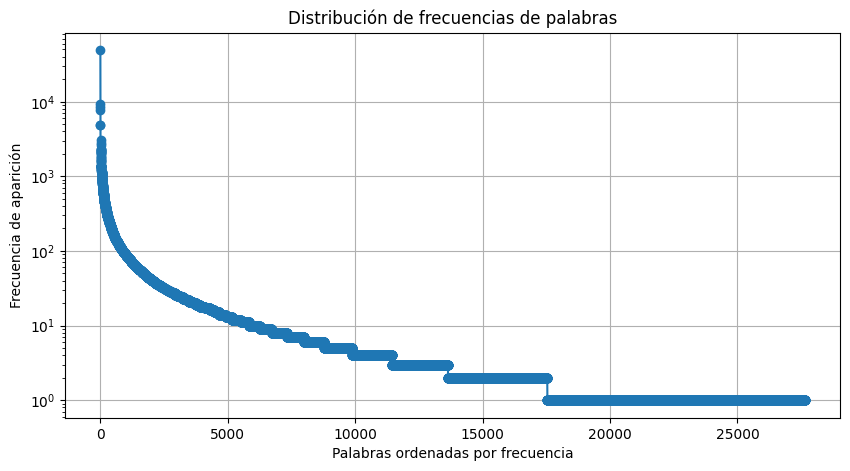

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Ordenamos las frecuencias en orden descendente para mejor interpretacion de la grafica
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gráfica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")

plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparición")
plt.title("Distribución de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

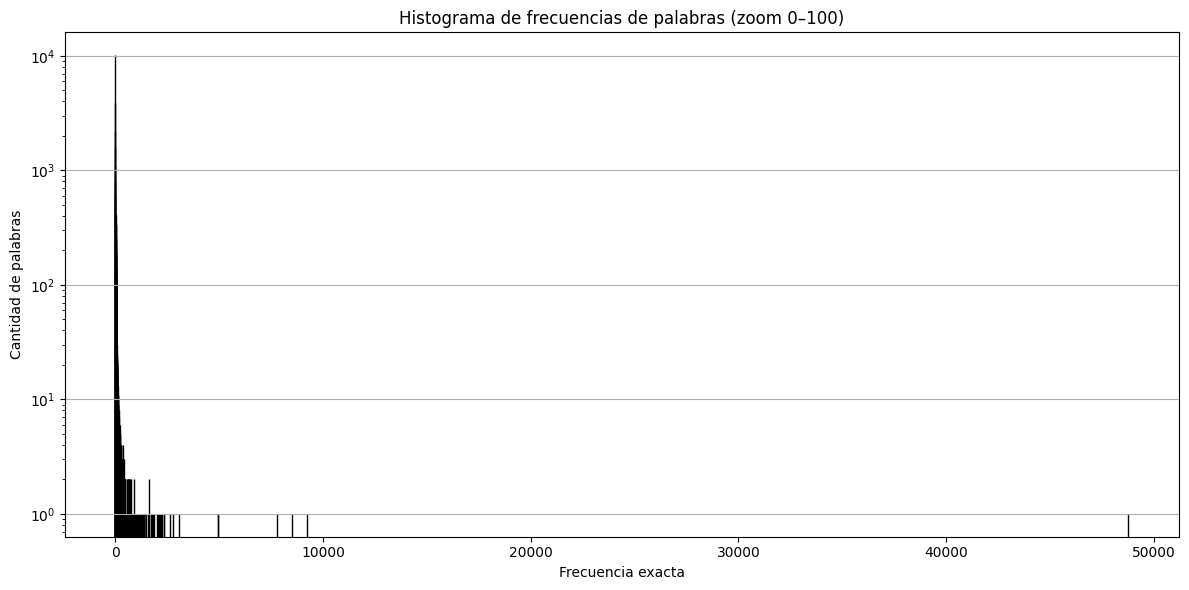

In [68]:

max_freq = int(max(word_frequencies))

plt.figure(figsize=(12,6))
plt.hist(word_frequencies, bins=np.arange(1, max_freq + 1), edgecolor='black', log=True)

plt.xlabel("Frecuencia exacta")
plt.ylabel("Cantidad de palabras")
plt.title("Histograma de frecuencias de palabras (zoom 0–100)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Viendo la gráfica, podemos observar que la mayoría de las palabras tienen una frecuencia de aparición muy baja. Por lo tanto, si seleccionamos un valor alto para `min_freq`, eliminaríamos demasiados datos relevantes. Por esta razón, se ha optado por un valor de `min_freq = 3`, que permite conservar un equilibrio entre eliminar ruido y mantener información útil.


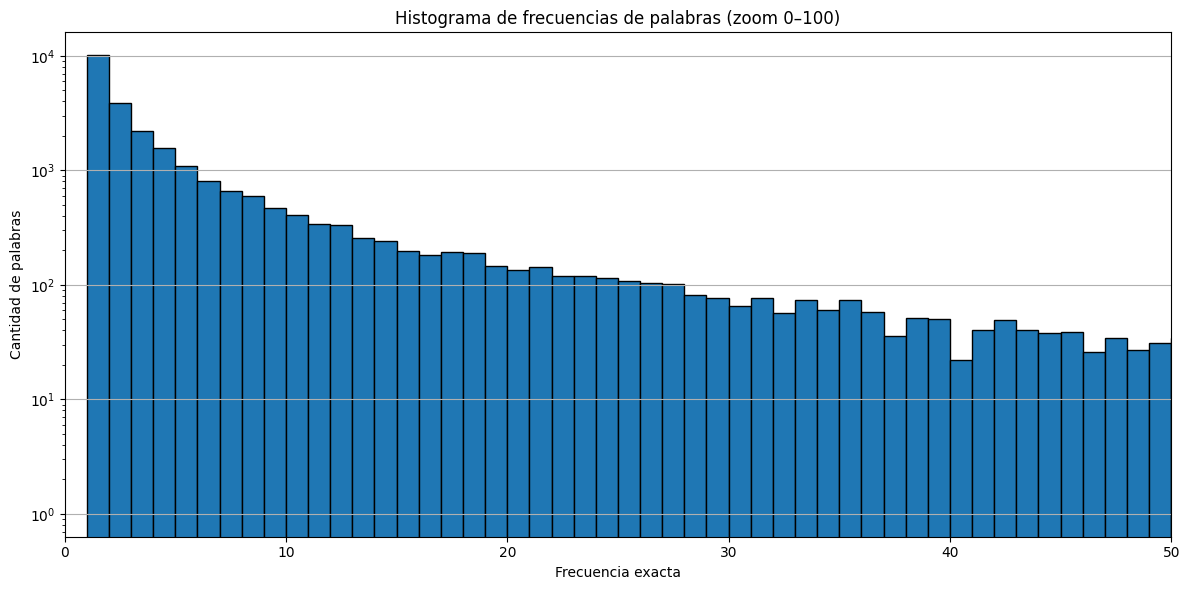

In [69]:
plt.figure(figsize=(12,6))
plt.hist(word_frequencies, bins=np.arange(1, max_freq + 1), edgecolor='black', log=True)

plt.xlabel("Frecuencia exacta")
plt.ylabel("Cantidad de palabras")
plt.title("Histograma de frecuencias de palabras (zoom 0–100)")
plt.grid(axis='y')
# 🔍 Zoom en el eje X
plt.xlim(0, 50)
plt.tight_layout()
plt.show()

In [70]:
min_freq = 3  # Umbral mínimo (si se pone mas agrande se eliminaran mas de la mitad de las observaciones)
vectorizer = CountVectorizer(min_df=min_freq)
X_filtered = vectorizer.fit_transform(train_aplanado)

Distribución de frequencias filtrada:

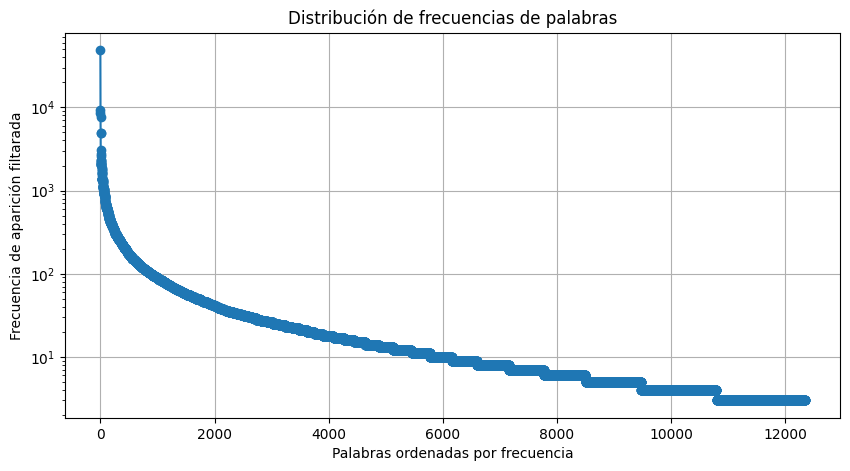

In [71]:
word_frequencies = X_filtered.sum(axis=0).A1
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gráfica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")
plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparición filtarada")
plt.title("Distribución de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

In [72]:
X_filtered.shape #train final

(1400, 12346)

# Modelos supervisados. Parte 1:

Una vez que los datos han sido preprocesados para facilitar la clasificación de los documentos, se procede a construir los modelos supervisados.

En esta práctica, se comparan tres modelos supervisados con enfoques significativamente diferentes: **KNN**, **Random Forest** y **SVM (Support Vector Machine)**. Para garantizar una evaluación justa, se sigue el mismo procedimiento de entrenamiento para cada modelo:

1. **Optimización de Hiperparámetros**: Se utiliza la función **GridSearchCV**, que entrena los modelos con diferentes particiones de **train** y **validation**, para encontrar los mejores parámetros que se ajusten a los datos de entrenamiento.

2. **Evaluación con Cross-Validation**: Una vez seleccionados los mejores parámetros, se aplica la función **cross_validate** para calcular métricas de rendimiento como accuracy, F1-score, precisión y recall, utilizando diferentes *folds*.

3. **Predicción con el test**: Una vez tenemos los modelos entrenados, los validamos con el dataset test.

In [73]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd

# datos
X = train_aplanado
y = train_labels

# Métricas que quieres evaluar
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Resultados globales
resultados = {}

# ----------- MODELO 1: KNN -----------
pipe_knn = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', KNeighborsClassifier())
])

param_knn = {
    'clf__n_neighbors': [3, 5, 7]
}

grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=5, scoring='accuracy')
grid_knn.fit(X, y)

mejor_knn = grid_knn.best_estimator_

# ----------- MODELO 2: Random Forest -----------
pipe_rf = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', RandomForestClassifier(random_state=42))
])

param_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 100]
}

grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=5, scoring='accuracy')
grid_rf.fit(X, y)
mejor_rf = grid_rf.best_estimator_

# ----------- MODELO 3: SVM -----------
pipe_svm = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', SVC())
])

param_svm = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(pipe_svm, param_grid=param_svm, cv=5, scoring='accuracy')
grid_svm.fit(X, y)
mejor_svm = grid_svm.best_estimator_

Se evaluaron los modelos supervisados (KNN, Random Forest y SVM) con `cross_validate` usando métricas como `accuracy`, `f1_macro`, `precision_macro` y `recall_macro`.

KNN mostró el peor rendimiento en todas las métricas debido a su ineficiencia en datos de alta dimensionalidad, por lo que no es adecuado. Random Forest logró un buen equilibrio entre precisión y recall, siendo una opción sólida. SVM destacó como el mejor modelo, obteniendo los mejores resultados en `accuracy` y `f1_macro`.

**Modelo Ganador**

SVM es el modelo más efectivo, superando ligeramente a Random Forest en precisión y F1-score.


In [74]:
# Diccionario de modelos a comparar
modelos = {
    "KNN": mejor_knn,
    "RandomForest": mejor_rf,
    "SVM": mejor_svm
}

# Guardamos resultados
resultados = {}

# mejor_knn, mejor_rf, mejor_svm son Pipelines que contienen el mejor modelo y el vectorizador. 
for nombre, modelo in modelos.items():
    cv_result = cross_validate(modelo, X, y, cv=5, scoring=scoring)

    resumen = {métrica: round(cv_result[f'test_{métrica}'].mean(), 4) for métrica in scoring}
    resultados[nombre] = resumen


# Mostrar como DataFrame ordenado
df_resultados = pd.DataFrame(resultados).T
print("🔍 Los mejores resultados de cada modelo:")
print(df_resultados)


🔍 Los mejores resultados de cada modelo:
              accuracy  f1_macro  precision_macro  recall_macro
KNN             0.6064    0.6005           0.6127        0.6064
RandomForest    0.8064    0.8060           0.8092        0.8064
SVM             0.8150    0.8149           0.8158        0.8150


## Aplicación al *test*

Después de obtener cada modelo con sus mejores parámetros a través de **GridSearch**, predecimos con estos modelos para los datos del test y obtenemos a partir de allí el accuracy y la matriz de confusión. 

In [75]:
# Con los mejores modelos entrenados, predecimos sobre el conjunto de test
X_test = [' '.join(sublista) for sublista in test_lemat]
y_test = test_labels

# Predicciones
y_pred_knn = mejor_knn.predict(X_test)
y_pred_rf = mejor_rf.predict(X_test)
y_pred_svm = mejor_svm.predict(X_test)

# Accuracy
acc_knn = mejor_knn.score(X_test, y_test)
acc_rf = mejor_rf.score(X_test, y_test)
acc_svm = mejor_svm.score(X_test, y_test)

# Matriz de Confusión
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)


Observamos que el modelo que ha obtenido el mejor resultado es el SVM, el Random Forest también ha obtenido resultados similares, el KNN sí que no ha obtenido resultados muy buenos.

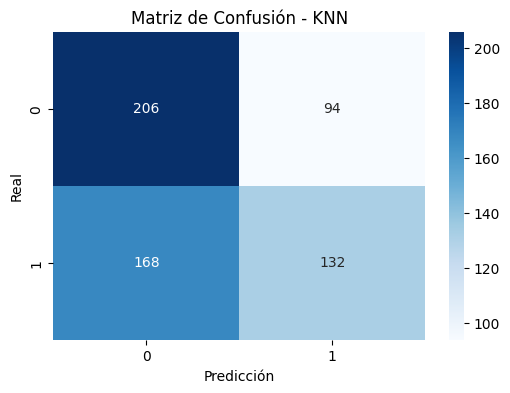

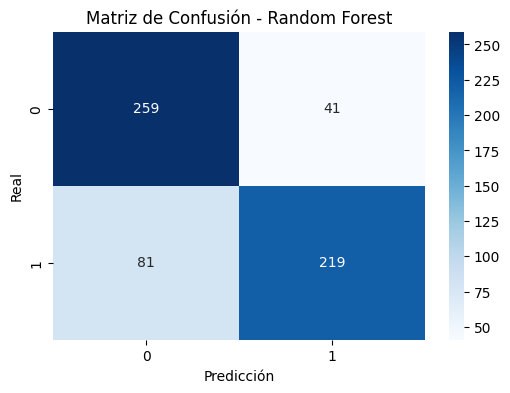

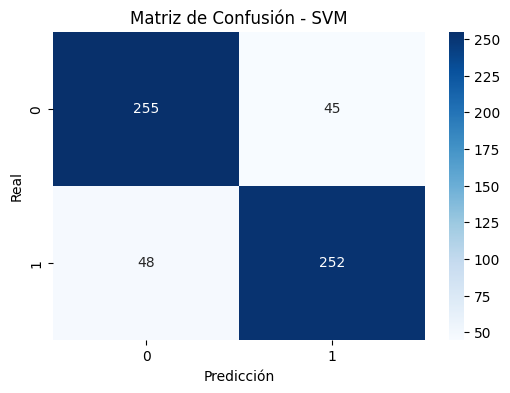

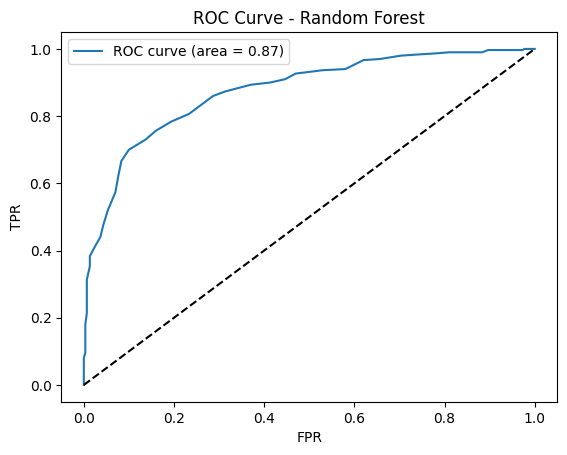

KNN:
               precision    recall  f1-score   support

           0       0.55      0.69      0.61       300
           1       0.58      0.44      0.50       300

    accuracy                           0.56       600
   macro avg       0.57      0.56      0.56       600
weighted avg       0.57      0.56      0.56       600

Random Forest:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       300
           1       0.84      0.73      0.78       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600

SVM:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85       300
           1       0.85      0.84      0.84       300

    accuracy                           0.84       600
   macro avg       0.85      0.84      0.84       600
weighted avg       0.85      0.84      0.84   

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

model_names = ['KNN', 'Random Forest', 'SVM']
cms = [cm_knn, cm_rf, cm_svm]
preds = [y_pred_knn, y_pred_rf, y_pred_svm]

for i, cm in enumerate(cms):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_names[i]}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Solo si es binario:
fpr, tpr, _ = roc_curve(y_test, mejor_svm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

print("KNN:\n", classification_report(y_test, y_pred_knn))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("SVM:\n", classification_report(y_test, y_pred_svm))

# Crear un diccionario con los accuracies
ranking_dict = {
    'Modelo': ['KNN', 'Random Forest', 'SVM'],
    'Accuracy': [acc_knn, acc_rf, acc_svm]
}

# Crear DataFrame y ordenarlo de mayor a menor
ranking_df = pd.DataFrame(ranking_dict)
ranking_df = ranking_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Mostrar el ranking
print("📊 Ranking de modelos según Accuracy:")
print(ranking_df)


# Modelos no supervisados. Parte 2:

En esta sección se aborda la clasificación de polaridad utilizando métodos no supervisados basados en recursos léxicos como SentiWordNet. El proceso se divide en las siguientes etapas:

1. **Preprocesamiento y Filtrado**: Se seleccionan las palabras más relevantes para el análisis de sentimientos, como adjetivos, verbos, sustantivos y adverbios, y se eliminan aquellas con baja frecuencia.

2. **Obtención de Synsets**: Se emplea principalmente el algoritmo de Lesk para identificar los synsets correspondientes a cada palabra en el contexto del documento.

3. **Asignación de Puntuaciones**: Se utilizan las puntuaciones de positividad y negatividad de SentiWordNet para calcular la polaridad de cada palabra y, posteriormente, del documento completo.

4. **Manejo de Synsets Ausentes**: Se implementan estrategias para tratar palabras cuyos synsets no están presentes en SentiWordNet, como la propagación de puntuaciones desde synsets relacionados o la asignación de valores neutros.

5. **Clasificación de Polaridad**: Se calcula un score global para cada documento, determinando si su polaridad es positiva, negativa o neutra.

In [77]:
from textserver import TextServer 
#ts = TextServer('jajajajaj', 'Text_2025', 'senses') 
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from collections import Counter

### Preprocesamiento:

Para el preprocesamiento de la segunda parte se han empleado las siguientes medidas:

- Filtrado por etiquetas POS relevantes (diccioanrio de POS que se pasan como un argumento), eliminando palabras que no aportan información útil para el análisis de sentimientos.  
- Eliminación de palabras con frecuencia menor al umbral `min_freq` para reducir ruido. 


In [78]:
def filtrar_y_limpiar(tagged_docs, etiquetas_validas, min_freq=3):
    # 1. Filtrar por etiquetas válidas
    filtrados_por_pos = [
        [w for w, tag in doc if tag in etiquetas_validas]
        for doc in tagged_docs
    ]

    # 2. Calcular frecuencias globales
    word_freq = Counter()
    for doc in filtrados_por_pos:
        word_freq.update(doc)

    # 3. Eliminar palabras con frecuencia < min_freq
    filtered_words = {word for word, freq in word_freq.items() if freq < min_freq}
    docs_filtrados = [
        [word for word in doc if word not in filtered_words]
        for doc in filtrados_por_pos
    ]

    return docs_filtrados

### Obtención de los synsets:

Hemos observado que TextServer es incapaz de detectar algunos synsets pero el algoritmo de Lesk sí, por ejemplo:

In [79]:
'''result = ts.senses('lively')[0][0]
print(result)
print(lesk(train_lemat[8], 'lively'))'''

"result = ts.senses('lively')[0][0]\nprint(result)\nprint(lesk(train_lemat[8], 'lively'))"

Por lo tanto, si el algoritmo de UKB es incapaz de encontrar el synset se va a intentar encontrarlo mediante Lesk:

In [80]:
# Algunos ejemplos son capaces de obtener el synset del lesk, pero no del Freeling.
def get_synsets(w, contexto):
    try:
        result = ts.senses(w)[0][0]
        categ = result[4][-1]
        id = int(result[4][0:8])
        synset1 = wn.synset_from_pos_and_offset(categ, id)
        return synset1
    except:
        return lesk(contexto, w) 

Se ha intentado solucionar el problema de senti_synsets no anotados para algunas palabras buscando el synsets de sus sinónimos, pero como que es demasiado costoso, tampoco se ha usado en la función del modelo.

In [81]:
#Metodo que incluye la busqueda de sinonimos

def get_synsets2(w, contexto):
    # 1. Intenta obtener el synset directamente con ts.senses
    try:
        result = ts.senses(w)[0][0]
        categ = result[4][-1]
        id = int(result[4][0:8])
        synset = wn.synset_from_pos_and_offset(categ, id)
        return synset
    except:
        pass  # Si falla, pasa al siguiente método
    
    # 2. Intenta con el algoritmo Lesk
    synset_lesk = lesk(contexto, w)
    if synset_lesk is not None:
        return synset_lesk
    
    # 3. Si todo falla, busca sinónimos y prueba con ellos
    synonyms = set()  
    
    # Obtenemos todos los lemas (sinónimos) de WordNet para la palabra
    for syn in wn.synsets(w):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ")  # Limpia guiones bajos
            if synonym.lower() != w:  # Evita la palabra original
                synonyms.add(synonym)
    
    # Probamos cada sinónimo con ts.senses y Lesk
    for synonym in synonyms:
        # Intenta con ts.senses
        try:
            result = ts.senses(synonym)[0][0]
            categ = result[4][-1]
            id = int(result[4][0:8])
            synset = wn.synset_from_pos_and_offset(categ, id)
            return synset
        except:
            pass
        
        # Intenta con Lesk si ts.senses falla
        synset_lesk = lesk(contexto, synonym)
        if synset_lesk is not None:
            return synset_lesk
    
    # Si nada funciona, retorna None 
    return None

#### ¿ Qué ocurre si el synset no está en SentiWordnet?

**1)Propagación basada en relaciones semánticas**

Utilizar la jerarquía de WordNet para propagar puntuaciones desde synsets relacionados.
- Buscar sinónimos del synset ausente
- Si se encuentra en SentiWordNet, propagar sus valores al synset ausente

PROBLEMA: El valor estará a una distancia semántica diferente que el valor real

**2)Asignación de valores neutros**

Asignar un valor neutral (0) a todos los synsets no encontrados.
Este enfoque asume que las palabras ausentes no contribuyen al sentimiento del texto. SentiWordNet se enfoca en palabras con carga emocional clara, y por tanto, las palabras ausentes probablemente sean neutras en términos de sentimiento.

- "La ausencia de ciertos términos en léxicos de sentimiento como SentiWordNet puede interpretarse como evidencia de su naturaleza semánticamente neutra en contextos evaluativos" (Baccianella et al., 2010).

### El método:

Clasificación de polaridad siguiendo la siguiente fórmula:

**score(s) = poss − neg**

Donde *poss* representa el score de positividad y *neg* el score de negatividad.
Cuando la fórmula se aplica a todo un texto, el resultado será un único valor numérico que representa la polaridad global del texto:

- Un valor positivo (+) indica que el texto tiene una tendencia general positiva
- Un valor negativo (-) indica que el texto tiene una tendencia general negativa
- Un valor cercano a cero sugiere que el texto es mayormente neutro

In [89]:

def predecir_sentimiento(lista_docs):
    etiquetas_predichas = []

    for doc in lista_docs:
        pos_s = 0
        neg_s = 0

        for w in doc:
            s1 = get_synsets2(w, doc)
            if s1 is not None:
                try:
                    senti_synset = swn.senti_synset(s1.name())
                    pos_s += senti_synset.pos_score()
                    neg_s += senti_synset.neg_score()
                except:
                    pass  # si no está en SentiWordNet
        etiquetas_predichas.append(1 if pos_s - neg_s >= 0 else 0)

    return etiquetas_predichas

**Comparación entre todos los POS y solo adjetivos**

Observaciones:
1. **Todos los POS relevantes**:
    - Incluye adjetivos, sustantivos, verbos y adverbios, proporcionando un análisis más completo.
    - Mejora la precisión al considerar más contexto.

2. **Solo adjetivos**:
    - Se enfoca en palabras emocionalmente cargadas.
    - Es más simple, pero puede perder información contextual.

Conclusión:
El uso de **todos los POS relevantes** ofrece mayor precisión y contexto, mientras que **solo adjetivos** es útil para enfoques rápidos y simplificados.


In [83]:
# Definir etiquetas útiles para sentimiento
POS_RELEVANTES = {'JJ', 'JJR', 'JJS',  # Adjetivos
                  'NN', 'NNS', 'NNP', 'NNPS',  # Sustantivos
                  'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbos
                  'RB', 'RBR', 'RBS'}  # Adverbios

SOLO_ADJETIVOS = {'JJ', 'JJR', 'JJS'}

In [84]:
# Accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_test = test_labels

test_relevantes = filtrar_y_limpiar(test_tagged, POS_RELEVANTES)
test_adjetivos = filtrar_y_limpiar(test_tagged, SOLO_ADJETIVOS)



In [90]:
pred_all = predecir_sentimiento(test_relevantes)
pred_adjetivos = predecir_sentimiento(test_adjetivos)



1. **Todos los POS relevantes**:
    - Capturan un contexto más amplio (adjetivos, sustantivos, verbos, adverbios).
    - Mayor riesgo de **falsos negativos** por ruido de palabras sin carga emocional.

2. **Solo adjetivos**:
    - Enfoque directo en palabras con carga emocional.
    - Mayor riesgo de **falsos positivos** al perder contexto.

**Conclusión**: Usar todos los POS es más equilibrado, mientras que solo adjetivos es más directo pero menos contextual. 


Accuracy considerando todos los POS: 0.66
Accuracy considerando solo los adjetivos: 0.65


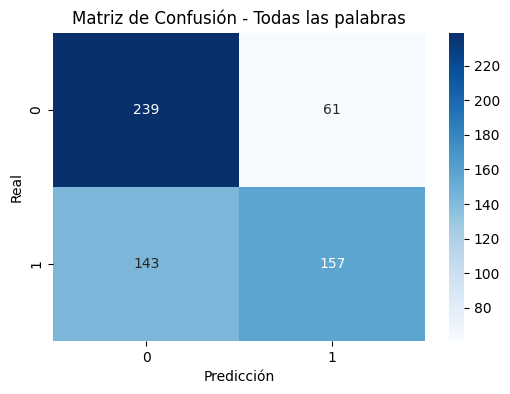

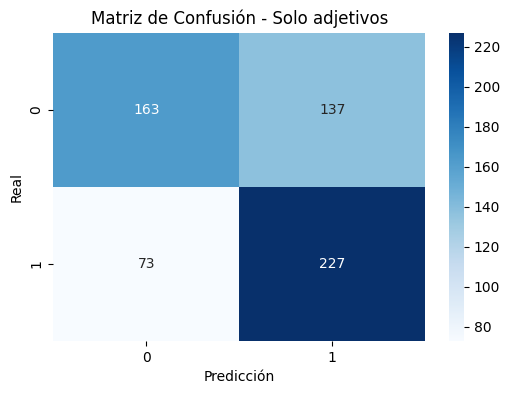

In [94]:
accuracy_all = accuracy_score(y_test, pred_all)
accuracy_adj = accuracy_score(y_test, pred_adjetivos)
print(f"Accuracy considerando todos los POS: {accuracy_all:.2f}")
print(f"Accuracy considerando solo los adjetivos: {accuracy_adj:.2f}")

# Matriz de Confusión
con_all = confusion_matrix(y_test, pred_all)
con_adj = confusion_matrix(y_test, pred_adjetivos)

plt.figure(figsize=(6, 4))
sns.heatmap(con_all, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Todas las palabras')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(con_adj, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Solo adjetivos')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


## Ampliació

Para lograr la ampliación de asignar pesos a los POS, primero hemos construido un base de datos de los **scores** característicos de cada documento para entrenar el modelo. Después ya podremos usar el modelo para predecir.


In [ ]:
# POS relevantes
POS_TAGS = {
    'adj': {'JJ', 'JJR', 'JJS'},
    'verb': {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'},
    'adv': {'RB', 'RBR', 'RBS'},
    'noun': {'NN', 'NNS', 'NNP', 'NNPS'}
}

def extract_pos_sentiment_features(tagged_docs):
    X = []
    for doc in tagged_docs:
        scores = {'adj': 0, 'verb': 0, 'adv': 0, 'noun': 0}
        tokens = [w for w, _ in doc]

        for w, tag in doc:
            pos_category = None
            for key, tag_set in POS_TAGS.items():
                if tag in tag_set:
                    pos_category = key
                    break
            if pos_category:
                syn = lesk(tokens, w)
                if syn:
                    try:
                        senti = swn.senti_synset(syn.name())
                        scores[pos_category] += senti.pos_score() - senti.neg_score()
                    except:
                        pass
        X.append([scores['adj'], scores['verb'], scores['adv'], scores['noun']])
    return np.array(X)

# Extraemos features
X_features = extract_pos_sentiment_features(train_tagged)
y = train_labels

# Métricas a evaluar
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Modelos
modelos = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Resultados
resultados = {}

for nombre, modelo in modelos.items():
    cv_result = cross_validate(modelo, X_features, y, cv=5, scoring=scoring)
    resumen = {métrica: round(np.mean(cv_result[f'test_{métrica}']), 4) for métrica in scoring}
    resultados[nombre] = resumen

# Mostrar tabla de resultados
df_resultados = pd.DataFrame(resultados).T
print("\n📊 Resultados promedio con cross-validation:")
print(df_resultados)

# ENTRENAR FINAL para mostrar importancias
print("\n🎯 Pesos finales entrenando con todo el dataset:")

rf_model = modelos["RandomForest"].fit(X_features, y)

# Importancias RF
print("\nImportancia por feature (RandomForest):")
for i, pos in enumerate(['adj', 'verb', 'adv', 'noun']):
    print(f"{pos}: {rf_model.feature_importances_[i]:.4f}")


🧪 Evaluando RandomForest...

📊 Resultados promedio con cross-validation:
              accuracy  f1_macro  precision_macro  recall_macro
RandomForest    0.6093    0.6089           0.6098        0.6093

🎯 Pesos finales entrenando con todo el dataset:

Importancia por feature (RandomForest):
adj: 0.2969
verb: 0.2318
adv: 0.2391
noun: 0.2322


**Balanceo de Errores**

Aunque el modelo no ha logrado mejorar significativamente el **accuracy**, sí ha conseguido **balancear los errores** entre las clases positivas y negativas. Esto es especialmente importante en problemas donde el desbalance de clases puede llevar a un modelo a favorecer una clase sobre la otra.

En este caso, el modelo ha reducido la cantidad de **falsos positivos** y **falsos negativos**, logrando una distribución más equitativa de los errores. Este balance es crucial en aplicaciones donde ambos tipos de errores tienen un impacto significativo, como en el análisis de sentimientos, donde clasificar incorrectamente un sentimiento positivo como negativo (o viceversa) puede llevar a interpretaciones erróneas.

Por lo tanto, aunque el **accuracy** no haya mejorado, el modelo es más robusto y confiable al manejar ambos tipos de errores de manera más equilibrada.

Accuracy: 0.64


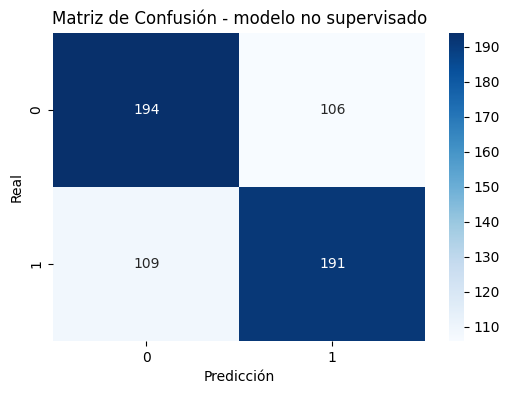

In [ ]:

def predecir_sentimiento_pond(tagged_docs_nuevos, modelo):
    # Extraer los features POS-sentiment
    X_nuevos = extract_pos_sentiment_features(tagged_docs_nuevos)

    # Predecir usando el modelo entrenado
    etiquetas_predichas = modelo.predict(X_nuevos)

    return etiquetas_predichas

# Nuevos documentos POS-tagged
predicciones = predecir_sentimiento_pond(test_tagged, rf_model)

# Accuracy
accuracy = accuracy_score(test_labels, predicciones)
print(f"Accuracy: {accuracy:.2f}")
# Matriz de Confusión
con = confusion_matrix(test_labels, predicciones)
plt.figure(figsize=(6, 4))
sns.heatmap(con, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusión - modelo no supervisado')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


## Comparación Métodos




**Conclusión**
El modelo SVM podria ser la mejor opción para este problema, destacando por su precisión y robustez. Sin embargo, el enfoque no supervisado basado en todos los POS es útil como alternativa inicial cuando no se dispone de datos etiquetados.
También hay que destacar como el modelo no supervisado tiene en cuenta los significados y la polaridad de las palabras.


SVM:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85       300
           1       0.85      0.84      0.84       300

    accuracy                           0.84       600
   macro avg       0.85      0.84      0.84       600
weighted avg       0.85      0.84      0.84       600

Modelo no supervisado:
               precision    recall  f1-score   support

           0       0.63      0.80      0.70       300
           1       0.72      0.52      0.61       300

    accuracy                           0.66       600
   macro avg       0.67      0.66      0.65       600
weighted avg       0.67      0.66      0.65       600



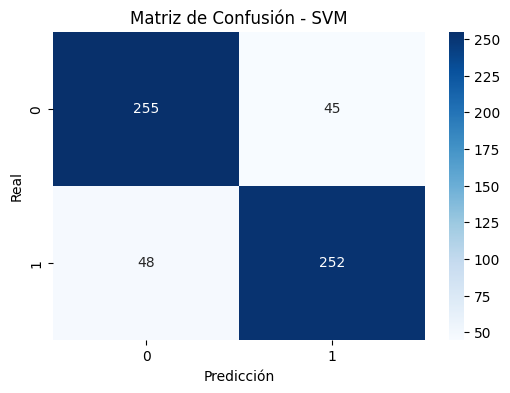

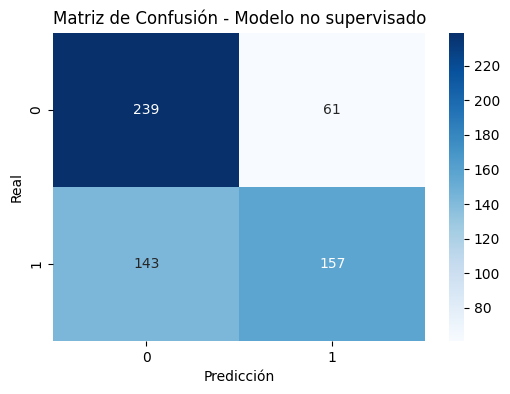

In [96]:
# classification_report de SVM y modelo no supervisado
from sklearn.metrics import classification_report

# SVM
print("SVM:\n", classification_report(y_test, y_pred_svm))

# Modelo no supervisado
print("Modelo no supervisado:\n", classification_report(test_labels, pred_all))

# Matriz de Confusión
con_svm = confusion_matrix(y_test, y_pred_svm)
con_modelo = confusion_matrix(test_labels, pred_all)

plt.figure(figsize=(6, 4))
sns.heatmap(con_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - SVM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(con_modelo, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Modelo no supervisado')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()